<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
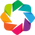

Populating the interactive namespace from numpy and matplotlib


In [36]:
# %load imports.py
import glob
import os

import h5py
import holoviews as hv
import numpy as np
import pandas as pd
import panel as pn
import param
import yaml
from holoviews import opts
from tqdm import tqdm

hv.extension("bokeh")
from bokeh.io import export_png, export_svgs

opts.defaults(
    opts.Scatter(width=1000, height=300),
    opts.Histogram(width=1000, height=300),
    opts.Image(width=1000, height=300),
    opts.Curve(width=1000, height=300),
    opts.Points(width=1000, height=300),
)


%pylab inline
# from matplotlib.colors import LogNorm
%config InlineBackend.figure_format ='retina'

rcParams["figure.figsize"] = (13.0, 6.0)

from scipy.optimize import curve_fit
from scipy.stats import norm


def get_data_pd(fname: str) -> pd.DataFrame:
    try:
        with h5py.File(fname, "r") as f:
            rawNr = f["raw/trigger nr"][:]
            rawTof = f["raw/tof"][:] * 1e6
            rawTot = f["raw/tot"][:]
            rawX = f["raw/x"][:]
            rawY = f["raw/y"][:]
            centNr = f["centroided/trigger nr"][:]
            centTof = f["centroided/tof"][:] * 1e6
            centTot = f["centroided/tot max"][:]
            centY = f["centroided/y"][:]
            centX = f["centroided/x"][:]

        raw_data = pd.DataFrame(
            np.column_stack((rawNr, rawTof, rawTot, rawX, rawY)),
            columns=("nr", "tof", "tot", "x", "y"),
        )
        cent_data = pd.DataFrame(
            np.column_stack((centNr, centTof, centTot, centX, centY)),
            columns=("nr", "tof", "tot", "x", "y"),
        )
        return raw_data, cent_data
    except:
        print(f'key "{keys}" not known or file "{fname}" not existing')


def gauss_fwhm(x, *p):
    A, mu, fwhm = p
    return A * np.exp(-((x - mu) ** 2) / (2.0 * (fwhm ** 2) / (4 * 2 * np.log(2))))


def find_peaks_in_microbunch(
    data: pd.DataFrame, nr_peaks: int = 4, dt: float = 10, offset: float = 0
) -> list:
    """find first peak in micro-bunch"""
    peaks = []
    for i in range(nr_peaks):
        mask = np.logical_and(
            data["tof"] > (offset + i * dt), data["tof"] < (offset + i * dt + 1)
        )
        x_hist, x_edges = np.histogram(data["tof"][mask], bins=1_000)
        x = (x_edges[:-1] + x_edges[1:]) * 0.5
        popt, pcov = curve_fit(
            gauss_fwhm, x, x_hist, p0=[x_hist.max(), x[x_hist.argmax()], 0.05]
        )
        peaks.append(popt[1])
    return peaks


def shift_microbunch_pulses(
    data: pd.DataFrame, nr_peaks: int = 4, dt: float = 10, offset: float = 0
) -> pd.DataFrame:
    """Fold consecutive micro-bunch pulses back to first"""
    peaks = find_peaks_in_microbunch(data, nr_peaks, dt, offset)

    # shift bunches
    for i in range(1, nr_peaks):
        mask = np.logical_and(
            data["tof"] >= offset + i * dt, data["tof"] < offset + (i + 1) * dt
        )
        data["tof"][mask] -= peaks[i] - peaks[0]

    return data


with open("runs.yaml") as f:
    runNrs = yaml.safe_load(f)

In [37]:
cmap = "Spectral_r"  # color map for velocity maps
import matplotlib.colors as mplc
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [38]:
import matplotlib.pyplot as plt

In [39]:
import dask
import dask.bag as db
from dask.distributed import Client

dask.config.set({"distributed.dashboard.link": "/user-redirect/proxy/{port}/status"})
# client = Client(n_workers=40, threads_per_worker=2)
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34215 Dashboard: /user-redirect/proxy/46341/status,Cluster Workers: 9 Cores: 72 Memory: 810.03 GB


In [40]:
def compute_covariance(mz: np.array, bins_mz: np.array) -> np.array:
    """compute 2D covariance map for every trigger event and sum them up"""
    # mz = data[...,2]# for Melby: [...,0]*1e6
    N = len(mz)
    # bins_mz = np.linspace(0, 5, 2000)

    # define necessary function for calculation dask
    @dask.delayed
    def calc_2d_hist(trigger_frames):
        h_2b = np.zeros(2 * (len(bins_mz) - 1,))
        for frame in trigger_frames:
            # call this in dash client
            h_1d_j = np.histogram(frame, bins=bins_mz)[0]
            h_2b += h_1d_j[:, None] * h_1d_j[None, :]
        return h_2b

    @dask.delayed
    def add_matrix(a, b):
        return a + b

    # calculate 2D histogram, covariance mape
    output = []
    for i in range(0, len(mz), 1024):
        output.append(calc_2d_hist(mz[i : i + 1024]))
    zs = dask.persist(*output)

    # tree summation
    empty = np.zeros(2 * (len(bins_mz) - 1,))
    L = zs
    while len(L) > 1:
        new_L = []
        for i in range(0, len(L), 2):
            if i + 1 < len(L):
                lazy = add_matrix(L[i], L[i + 1])
            else:
                lazy = add_matrix(L[i], empty)
            new_L.append(lazy)
        L = new_L

    h_2b = dask.compute(L)[0][0]

    return h_2b

# Prepare data

In [41]:
file = "out/ion-run_0016_20200903-2202.hdf5"
name = os.path.basename(file).rstrip(".hdf5")
data_raw, data_cent = get_data_pd(file)

In [42]:
peaks = find_peaks_in_microbunch(
    data_cent,
    nr_peaks=runNrs[name]["pulses"],
    dt=1 / runNrs[name]["rep"] * 1e3,
    offset=0.9,
)

In [43]:
mask = np.logical_and(data_cent["tof"] > 0, data_cent["tof"] < 20)
x_hist, x_edges = np.histogram(data_cent["tof"][mask], bins=1_000)
a = hv.Histogram((x_hist, x_edges)).opts(
    title=f'{name}: {runNrs[name]["sample"]}, {runNrs[name]["pulses"]}x{runNrs[name]["rep"]} kHz',
    xlabel="TOF (µs)",
    width=1200,
)
b = [hv.VLine(i).opts(line_width=0.5) for i in peaks]
a * b[0] * b[1] * b[2] * b[3] * b[4]

:Overlay
   .Histogram.I :Histogram   [x]   (Frequency)
   .VLine.I     :VLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .VLine.III   :VLine   [x,y]
   .VLine.IV    :VLine   [x,y]
   .VLine.V     :VLine   [x,y]

data_shifted = shift_microbunch_pulses(data_cent, nr_peaks=runNrs[name]["pulses"], dt=1/runNrs[name]["rep"]*1e3, offset=0.9)

In [44]:
# http://holoviews.org/reference/elements/matplotlib/ErrorBars.html
# https://www.nuomiphp.com/eplan/en/29552.html
peaks = find_peaks_in_microbunch(
    data_cent,
    nr_peaks=runNrs[name]["pulses"],
    dt=1 / runNrs[name]["rep"] * 1e3,
    offset=0.9,
)
p = np.polyfit(range(len(peaks)), peaks, deg=1)
poly1d_fn = np.poly1d(p)
x = range(len(peaks))
y = peaks

errors = np.column_stack((x, y, poly1d_fn(x) - y))
hv.Curve((x, poly1d_fn(x))).opts(height=400) * hv.Scatter(errors).opts(
    xlabel="Peak number", ylabel="Peak pos (µs)", color="red"
) * hv.ErrorBars(errors)

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .Scatter.I   :Scatter   [x]   (y)
   .ErrorBars.I :ErrorBars   [x]   (y,yerror)

In [45]:
curve_fit(lambda x, m, t: m * x + t, range(len(peaks)), peaks)

(array([3.98767582, 1.50205528]),
 array([[ 2.95084420e-11, -1.03279548e-10],
        [-1.03279548e-10,  5.16397721e-10]]))

In [46]:
trigger_nr = data_cent["nr"]

In [47]:
%%time


def foo(i):
    return np.where(trigger_nr == i)[0]


futures = []
nraxis = np.unique(trigger_nr)  # get valid event Nrs
b = db.from_sequence(nraxis, npartitions=100)
b = b.map(foo)

CPU times: user 1.52 s, sys: 264 ms, total: 1.78 s
Wall time: 1.74 s


In [48]:
%time slices = b.compute()

CPU times: user 11.1 s, sys: 4.96 s, total: 16.1 s
Wall time: 36 s


In [49]:
# test if number of events in slices is the same as in trigger events
_, trigger_frame_len = np.unique(data_cent["nr"], return_counts=True)
x_hist, x_edges = np.histogram(trigger_frame_len, bins=100)
a = hv.Histogram((x_edges[:-1], x_hist)).opts(
    xlabel="Number of clusters per trigger event"
)
assert (
    np.sum(list(map(len, slices)) - trigger_frame_len) == 0
), "the two arrays do not have the same content"
a

:Histogram   [x]   (Frequency)

In [50]:
maxlen = np.max(list(map(len, slices)))
print(f"longest mask: {maxlen}")

longest mask: 105


In [51]:
# slice vz~0
# original from CH3I_TOFs.ipynb

from scipy.constants import physical_constants

x_cent, y_cent, radius = 136, 140, 112
# https://www.wolframalpha.com/input/?i=26.5713+mm%2F%2810+mm%2Fus+*+2.2567+us%29 from Benjamin Email
vmi_magnification = 28.6445 / (10 * 2.4275)
c_pixel = 78 / (2 * radius) * 1e-3  # 78mm / (224 pixel) conversion von pixel nach m
# https://confluence.desy.de/display/TPX3BT/2020/12/17/VMI+calibration+with+Simion
tof_offset = 0.926 - 0.12  # arrival time of photon peak

df = data_cent.query("tof >= 3.1 & tof < 3.3")
df["tof"] -= tof_offset
df["x_rel"] = df["x"] - x_cent
df["y_rel"] = df["y"] - y_cent
df["r"] = np.sqrt(df["x_rel"] ** 2 + df["y_rel"] ** 2)
df["theta"] = np.arctan2(
    df["y_rel"], df["x_rel"]
)  # alternatively: np.arctan2(df['y'], df['r'])
df["v_x"] = df["x_rel"] * c_pixel / vmi_magnification / (df["tof"] * 1e-6)  # m/s
df["v_y"] = df["y_rel"] * c_pixel / vmi_magnification / (df["tof"] * 1e-6)  # m/s
df["xy_velocity"] = (
    df["r"] * c_pixel / vmi_magnification / (df["tof"] * 1e-6)
)  # for m/s

x_hist, x_edges = np.histogram(df["tof"], bins=100)
x = 0.5 * (x_edges[1:] + x_edges[:-1])
popt, pcov = curve_fit(
    gauss_fwhm, x, x_hist, p0=[x_hist.max(), x[x_hist.argmax()], 0.20]
)

e = physical_constants["elementary charge"][0]  # C
u = physical_constants["atomic mass constant"][0]
E = 269.5 * 100  # 158.9 * 100  # V/m, from Benjamins Simion simulation
m = 14.0067 * u  # kg
Δt = (df["tof"] - popt[1]) * 1e-6  # convert to s
df["vz"] = Δt * e * E / m

tof_t0 = popt[1] + tof_offset

In [52]:
Δt = 15_000 * 1e6 * m / e / E  # calculate TOF in µs from vz

In [53]:
# fit first peak
df = data_cent.query("tof >= 3.1 & tof < 3.3")
x_hist, x_edges = np.histogram(df["tof"], bins=200)
x = 0.5 * (x_edges[1:] + x_edges[:-1])
popt, pcov = curve_fit(
    gauss_fwhm, x, x_hist, p0=[x_hist.max(), x[x_hist.argmax()], 0.20]
)

x = 0.5 * (x_edges[1:] + x_edges[:-1])
b = hv.Curve(
    (x, gauss_fwhm(x, *popt)), label=f"FWHM {1e3*popt[2]:.1f} ns, x₀={popt[1]:.3f} µs"
)
hv.Histogram((x_hist, x_edges)).opts(
    xlabel="TOF (µs)", title="N₂ from 1st micro-bunch"
) * b * hv.VLine(tof_t0 - Δt) * hv.VLine(tof_t0 + Δt)

:Overlay
   .Histogram.I                                                                   :Histogram   [x]   (Frequency)
   .Curve.FWHM_65_full_stop_5_ns_comma_x_subscript_zero_equals_3_full_stop_177_µs :Curve   [x]   (y)
   .VLine.I                                                                       :VLine   [x,y]
   .VLine.II                                                                      :VLine   [x,y]

In [54]:
# see if calculated offset is correct
df = data_cent.query("tof >= 7.1 & tof < 7.33")
df["tof"] -= peaks[1] - peaks[0]
x_hist, x_edges = np.histogram(df["tof"], bins=200)
x = 0.5 * (x_edges[1:] + x_edges[:-1])
popt, pcov = curve_fit(
    gauss_fwhm, x, x_hist, p0=[x_hist.max(), x[x_hist.argmax()], 0.20]
)

x = 0.5 * (x_edges[1:] + x_edges[:-1])
b = hv.Curve(
    (x, gauss_fwhm(x, *popt)), label=f"FWHM {1e3*popt[2]:.1f} ns, x0={popt[1]:.3f} µs"
)
hv.Histogram((x_hist, x_edges)).opts(
    xlabel="TOF (µs)", title="N₂ from 2nd micro-bunch, backfolded"
) * b

:Overlay
   .Histogram.I                                                     :Histogram   [x]   (Frequency)
   .Curve.FWHM_65_full_stop_8_ns_comma_x0_equals_3_full_stop_177_µs :Curve   [x]   (y)

In [55]:
# convert tof to m/q
def tof2moq(tof, t0=0.88482516, C=0.61225762):
    """returns mass over charge as a function of time of flight"""
    moq = ((tof - t0) / C) ** 2
    return moq

In [60]:
%%time

# df = data_cent.query("x > 121 & x < 151")
# df.reset_index(drop=True, inplace=True)
df = data_cent
trigger_nr = df["nr"]


def foo(i):
    return np.where(trigger_nr == i)[0]


futures = []
nraxis = np.unique(trigger_nr)  # get valid event Nrs
b = db.from_sequence(nraxis, npartitions=100)
b = b.map(foo)

CPU times: user 1.55 s, sys: 258 ms, total: 1.81 s
Wall time: 1.75 s


In [61]:
%time slices = b.compute()
maxlen = np.max(list(map(len, slices)))
print(f"longest mask: {maxlen} in {len(slices)} slices")

CPU times: user 10.7 s, sys: 5.15 s, total: 15.9 s
Wall time: 36.5 s
longest mask: 105 in 72007 slices


In [62]:
len(np.unique(data_cent["nr"]))

72007

In [63]:
%%time

offset = 0.9
dt = 1 / runNrs[name]["rep"] * 1e3
nr_peaks = runNrs[name]["pulses"]
peaks = find_peaks_in_microbunch(data_cent, nr_peaks=nr_peaks, dt=dt, offset=offset)

nr_events = len(slices)
# initialize empty data array and fill with data
data = np.zeros((nr_peaks * nr_events, maxlen, 3))


@dask.delayed
def micro_pulse_into_data(peak_idx):
    delta = peaks[peak_idx] - peaks[0]

    data = np.zeros((len(slices), maxlen, 3))
    for i, mask in tqdm(enumerate(slices)):
        mask = mask.tolist()
        if len(mask) > 0:
            # shift bunches for whole spectrum
            mask_peak = np.logical_and(
                df["tof"][mask] >= offset + peak_idx * dt,
                df["tof"][mask] < offset + (peak_idx + 1) * dt,
            )
            # tof_t0 gauss fit x0
            # shift peak
            # mask_peak = np.logical_and(
            #    data_cent["tof"][mask] >= peaks[peak_idx] + tof_t0 - peaks[0] - Δt,
            #    data_cent["tof"][mask] <= peaks[peak_idx] + tof_t0 - peaks[0] + Δt,
            # )
            mask_length = mask_peak.sum()  # summation True to see how long the is
            if mask_length > 0:
                data[i, :mask_length, 0] = df["x"][mask][mask_peak]
                data[i, :mask_length, 1] = df["y"][mask][mask_peak]
                data[i, :mask_length, 2] = tof2moq(
                    df["tof"][mask][mask_peak] - delta
                )  # convert ToF to moq
                # data[i, :len(mask), 3] = data_cent['tot'][mask]#tot[mask]

    return data


output = []
for peak_idx in range(0, nr_peaks):
    output.append(micro_pulse_into_data(peak_idx))
data_dask = dask.compute(dask.persist(*output))
data_dask = np.concatenate(data_dask[0])

CPU times: user 34.9 s, sys: 6.96 s, total: 41.8 s
Wall time: 3min 54s


In [ ]:
%%time
mz = data_dask[..., 2]  # data[:72007,:,2]
bins_mz = np.linspace(0, 30, 5_000)
h_2b = compute_covariance(mz, bins_mz).copy()

In [ ]:
hv.Histogram(
    np.histogram(
        data_dask[..., 2][(data_dask[..., 2] > 0) & (data_dask[..., 2] < 30)],
        bins=1_000,
    )
).opts(xlabel="moq")

In [ ]:
plt.imshow(h_2b, norm=mplc.LogNorm(), extent=2 * [bins_mz[0], bins_mz[-1]])
plt.colorbar()

In [ ]:
h_1d = np.histogram(mz.ravel(), bins=bins_mz)[0] / len(data)
h_2d = h_1d[:, None] * h_1d[None, :]
j1d = np.arange(len(bins_mz) - 1)
jx, jy = np.meshgrid(j1d, j1d, indexing="ij")
h_2d[jx >= jy] = 0
h_2b[jx >= jy] = 0

# subtract correlated from uncorrelated map:
h_cov = h_2b / len(mz) - h_2d

In [ ]:
np.savez("out/PIPICO_N2_moq_sliceX", h_cov=h_cov, bins_mz=bins_mz)

# with np.load('out/PIPICO_N2_moq.npz') as data:
#    mz = data['mz']
#    h_2b = data['h_2b']
#    bins_mz = data['bins_mz']

In [ ]:
plt.rcParams["font.size"] = "24"

In [ ]:
ext_2b = 2 * [bins_mz[0], bins_mz[-1]]
plt.imshow(
    h_cov.T,
    origin="lower",
    extent=ext_2b,
    interpolation="nearest",
    norm=mplc.LogNorm(),
    cmap="afmhot_r",
)
plt.xlabel("m₁/q₁ (u/e)")
plt.ylabel("m₂/q₂ (u/e)")
# plt.title(f'raw un-centroided {fname}')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(
    h_cov.T,
    origin="lower",
    extent=ext_2b,
    interpolation="nearest",
    norm=mplc.LogNorm(),
    vmin=1e-7,
    vmax=1e-3,
    #           norm=mplc.SymLogNorm(linthresh=1e-3), vmin=-10, vmax=10,
    cmap="afmhot_r",
)
# plt.colorbar()
ax.set_xlabel("m₁/q₁ (u/e)")
ax.set_ylabel("m₂/q₂ (u/e)")
# Set tick font size
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(16)
# plt.ylim(3.1, 3.3)
# plt.xlim(3.1, 3.3)
plt.tight_layout()
# plt.savefig('images/PIPICO_N2.png')

![https://doi.org/10.1103/PhysRevA.94.013426](https://journals.aps.org/pra/article/10.1103/PhysRevA.94.013426/figures/2/medium)
 
Photoion-photoion coincidence map showing the ion breakup channels of N2 from x-ray-pump–x-ray-probe measurements. The axes are the times of flight (TOFs) of the two ions that are detected in coincidence and a momentum conservation filter has been applied. The color intensity scale is normalized to 6720 maximum counts and the total counts is 49 680.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(
    h_cov.T,
    origin="lower",
    extent=ext_2b,
    interpolation="nearest",
    norm=mplc.LogNorm(),
    vmin=1e-9,
    vmax=1e-3,
    #           norm=mplc.SymLogNorm(linthresh=1e-3), vmin=-10, vmax=10,
    cmap="afmhot_r",
)
# plt.colorbar()
ax.set_xlim(6, 16)
ax.set_ylim(12, 16)
ax.set_xlabel("m₁/q₁ (u/e)")
ax.set_ylabel("m₂/q₂ (u/e)")
# ax.tight_layout()
# plt.savefig('images/PIPICO_N2_zoom.png')

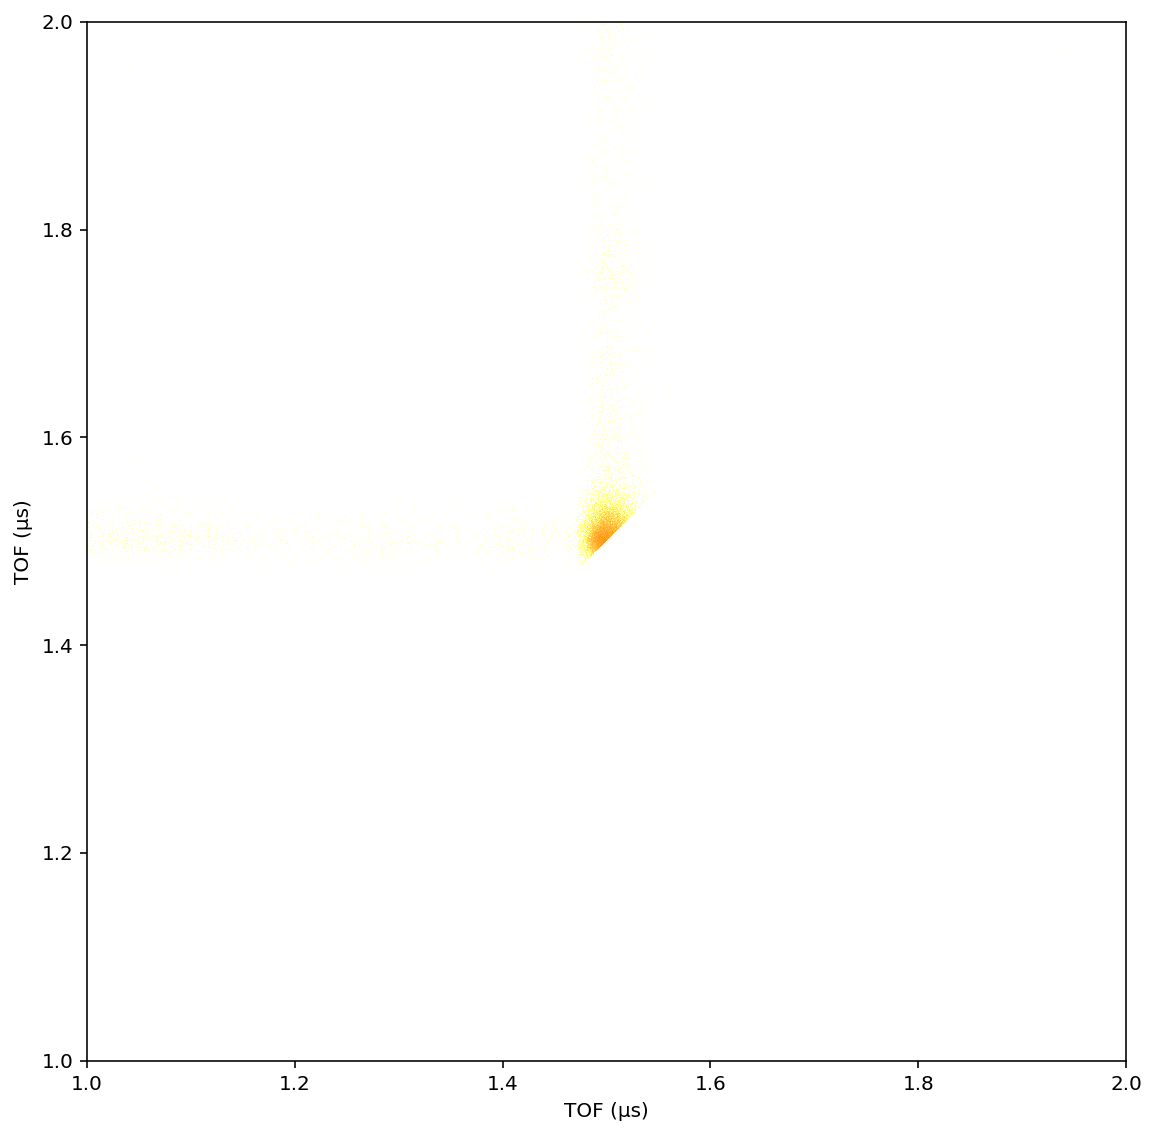

In [36]:
plt.figure(figsize=(8, 8))
plt.imshow(
    h_cov.T,
    origin="lower",
    extent=ext_2b,
    interpolation="nearest",
    norm=mplc.LogNorm(),
    vmin=1e-6,
    vmax=5e-1,
    #           norm=mplc.SymLogNorm(linthresh=1e-3), vmin=-10, vmax=10,
    cmap="afmhot_r",
)
# plt.colorbar()
plt.xlim(1, 2)
plt.ylim(1, 2)
plt.xlabel("TOF (µs)")
plt.ylabel("TOF (µs)")
plt.tight_layout()

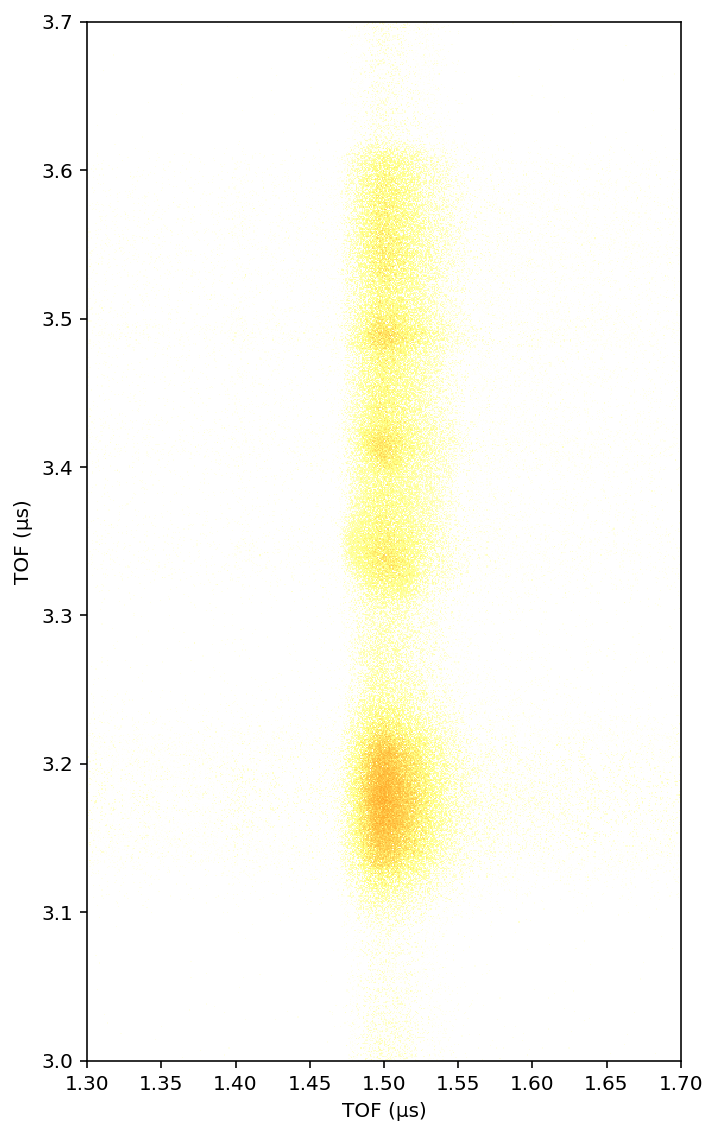

In [41]:
plt.figure(figsize=(8, 8))
plt.imshow(
    h_cov.T,
    origin="lower",
    extent=ext_2b,
    interpolation="nearest",
    norm=mplc.LogNorm(),
    vmin=1e-6,
    vmax=5e-1,
    #           norm=mplc.SymLogNorm(linthresh=1e-3), vmin=-10, vmax=10,
    cmap="afmhot_r",
)
# plt.colorbar()
plt.xlim(1.3, 1.7)
plt.ylim(3, 3.7)
plt.xlabel("TOF (µs)")
plt.ylabel("TOF (µs)")
plt.tight_layout()